In [9]:
import os
import time
from faster_whisper import WhisperModel
import speech_recognition as sr

FRENCH = False

In [2]:
with open('phrases.txt', 'r', encoding='utf-8') as f:
    original_sentences = f.readlines()

# GENERATE TRANSCRIPTIONS

In [3]:
# Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'

## Faster Whisper

In [4]:
def transcribe_sentences_faster_whisper(model, sentences, model_name):
    transcribed_sentences = []
    transcription_time = []

    for i, phrase in enumerate(sentences):
        print("\r" + str(i+1) + ": " + phrase.strip() + "                                          ", end="", flush=True)
        audio_file = f"audio_phrases/audio_recorded_{i+1}.wav"
        start = time.time()
        segments, info = model.transcribe(audio_file)
        finish = time.time()
        transcription_time.append(finish-start)
        transcribed_sentences.append("".join([segment.text for segment in segments]))

        time.sleep(0.1)

    with open(f'transcribed_sentences_{model_name}.txt', 'w', encoding='utf-8') as f:
        for sentence in transcribed_sentences:
            f.write(sentence + "\n")
    
    with open(f'transcription_time_{model_name}.txt', 'w', encoding='utf-8') as f:
        for ttime in transcription_time:
            f.write(str(ttime) + "\n")

In [5]:
models = ["small", "medium", "large"] # ["tiny", "base", "small", "medium", "large"]

for model_name in models:
    print(f"Transcribing with {model_name} model...")
    model = WhisperModel(model_name, device="cuda", compute_type="float16")
    transcribe_sentences_faster_whisper(model, original_sentences, model_name)

Transcribing with small model...
12: La musique transcende les frontières linguistiques.                                                   

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001C25B9E3CD0>>
Traceback (most recent call last):
  File "C:\Users\echriston\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


36: La curiosité est le moteur de la découverte.                                                                   

## Recognize Google

In [5]:
def transcribe_sentences_google(sentences):
    transcribed_sentences = []
    transcription_time = []

    r = sr.Recognizer()

    for i, phrase in enumerate(sentences):
        print("\r" + str(i+1) + ": " + phrase.strip() + "                                          ", end="", flush=True)
        audio_file = f"audio_phrases/audio_recorded_{i+1}.wav"
        # use the audio file as the audio source
        start = time.time()
        with sr.AudioFile(audio_file) as source:
            audio = r.record(source)  # read the entire audio file

        # recognize speech using Google Speech Recognition
        try:
            transcribed_sentences.append(r.recognize_google(audio, language="fr-FR") + ".")
        except sr.UnknownValueError:
            transcribed_sentences.append("")
        except sr.RequestError as e:
            transcribed_sentences.append("")
        finish = time.time()
        transcription_time.append(finish-start)

    with open('transcribed_sentences_google.txt', 'w', encoding='utf-8') as f:
        for sentence in transcribed_sentences:
            f.write(sentence + "\n")
    
    with open('transcription_time_google.txt', 'w', encoding='utf-8') as f:
        for ttime in transcription_time:
            f.write(str(ttime) + "\n")

In [ ]:
transcribe_sentences_google(original_sentences)

100: À quelle heure commence la réunion demain matin ?                                                               

# METRICS AND EVALUATIONS

In [4]:
def normalize_sentence(sentence):
    res = sentence.lower()
    res = res.replace("«", "")
    res = res.replace("»", "")
    res = res.replace("(", "")
    res = res.replace(")", "")
    res = res.replace("[", "")
    res = res.replace("]", "")
    res = res.replace("—", "-")
    res = res.replace("–", "-")
    res = res.replace("…", "...")
    res = res.replace("№", "n")
    res = res.replace("œ", "oe")
    res = res.replace("æ", "ae")
    res = res.replace(", ", " , ")
    res = res.replace(". ", " . ")
    res = res.replace("! ", " ! ")
    res = res.replace("? ", " ? ")
    res = res.replace(":", " : ")
    res = res.replace(";", " ; ")
    res = res.replace("  ", " ")
    res = res.replace("  ", " ")
    res = res.replace("  ", " ")
    return res

def normalize_sentences(sentences):
    return [normalize_sentence(sentence) for sentence in sentences]

In [5]:
def accuracy(original_sentences, transcribed_sentences):
    correct = 0
    total = 0

    for original, transcribed in zip(original_sentences, transcribed_sentences):
        if original.strip() == transcribed.strip():
            correct += 1
        total += 1
        
    return correct / total

def words_accuracy(original_sentences, transcribed_sentences):
    correct = 0
    total = 0

    def only_keep_letters(s):
        return "".join([c for c in s if c.isalpha() or c == " "])

    for original, transcribed in zip(original_sentences, transcribed_sentences):
        if only_keep_letters(original).strip() == only_keep_letters(transcribed).strip():
            correct += 1
        total += 1
    
    return correct / total
        

def wer(original_sentences, transcribed_sentences):
    total_wer = 0

    for original, transcribed in zip(original_sentences, transcribed_sentences):
        original = original.strip().split()
        transcribed = transcribed.strip().split()

        n = len(original) # number of words in the original sentence
        m = len(transcribed) # number of words in the transcribed sentence

        dp = [[0]*(m+1) for _ in range(n+1)] # dp[i][j] is the minimum number of operations to convert the first i words of the original sentence to the first j words of the transcribed sentence

        for i in range(n+1): # base case
            dp[i][0] = i

        for j in range(m+1): # base case
            dp[0][j] = j

        for i in range(1, n+1): 
            for j in range(1, m+1):
                if original[i-1] == transcribed[j-1]: # words are the same
                    dp[i][j] = dp[i-1][j-1] # no operation needed
                else:
                    dp[i][j] = min(dp[i-1][j-1], dp[i-1][j], dp[i][j-1]) + 1 # insert, delete or replace

        total_wer += dp[n][m] / n # normalize by the number of words in the original sentence

    return total_wer / len(original_sentences)



In [6]:
# load transcribed sentences

models = ["tiny", "base", "small", "medium", "large", "google"]

data = {}

for model_name in models:
    with open(f'transcribed_sentences_{model_name}.txt', 'r', encoding='utf-8') as f:
        transcribed_sentences = f.readlines()
    
    transcribed_sentences_normalized = normalize_sentences(transcribed_sentences)
    original_sentences_normalized = normalize_sentences(original_sentences)
    
    acc = accuracy(original_sentences_normalized, transcribed_sentences_normalized)
    words_acc = words_accuracy(original_sentences_normalized, transcribed_sentences_normalized)
    wer_score = wer(original_sentences_normalized, transcribed_sentences_normalized)

    with open(f'transcription_time_{model_name}.txt', 'r', encoding='utf-8') as f:
        transcription_time = f.readlines()
    
    # str to float
    transcription_time = [float(time) for time in transcription_time]

    data[model_name] = {
        "acc": acc,
        "words_acc": words_acc,
        "wer": wer_score,
        "transcription_time": transcription_time
    }

    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  WER: {wer_score}")
    print()


Model: tiny
  Accuracy: 0.12
  WER: 0.42224025974025986

Model: base
  Accuracy: 0.25
  WER: 0.27890223665223657

Model: small
  Accuracy: 0.55
  WER: 0.10175829725829724

Model: medium
  Accuracy: 0.8
  WER: 0.035349206349206345

Model: large
  Accuracy: 0.82
  WER: 0.03684523809523809

Model: google
  Accuracy: 0.56
  WER: 0.13254870129870133



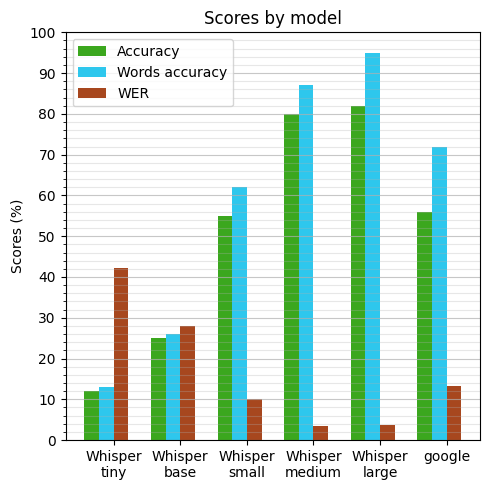

model: google, median: 1.5587006640434264
model: large, median: 0.37573348999023437
model: medium, median: 0.2548849105834961
model: small, median: 0.17373720169067383
model: base, median: 0.14663053989410402
model: tiny, median: 0.14314379215240478


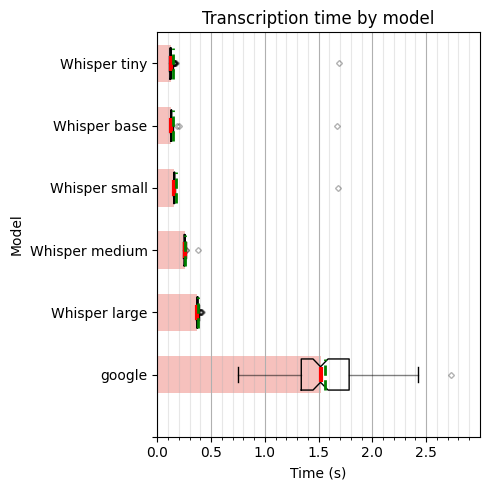

Model: tiny, mean: 0.14314379215240478, std: 0.15568730219009055, time: 0.14314379215240478 +- 0.15568730219009055
Model: base, mean: 0.14663053989410402, std: 0.1533112166979583, time: 0.14663053989410402 +- 0.1533112166979583
Model: small, mean: 0.17373720169067383, std: 0.15147661174507077, time: 0.17373720169067383 +- 0.15147661174507077
Model: medium, mean: 0.2548849105834961, std: 0.013644837626421779, time: 0.2548849105834961 +- 0.013644837626421779
Model: large, mean: 0.37573348999023437, std: 0.00918522083361484, time: 0.37573348999023437 +- 0.00918522083361484
Model: google, mean: 1.5587006640434264, std: 0.3646297562101037, time: 1.5587006640434264 +- 0.3646297562101037


In [13]:
# bar plot of all normalized metrics
import matplotlib.pyplot as plt
import numpy as np


labels = list(data.keys())
# add whisper before labels except for google, ex: tiny -> Whisper tiny
labels_str = ["Whisper\n" + label if label != "google" else label for label in labels]

myacc, mywacc, mywer, mytime = zip(*[data[model_name].values() for model_name in labels])

myacc_100 = [100 * acc for acc in myacc]
mywacc_100 = [100 * acc for acc in mywacc]
mywer_100 = [100 * acc for acc in mywer]

x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots(figsize=(5, 5))  # Adjust figsize as needed
# 3 rects for each model
width = 0.22  # the width of the bars
rects1 = ax.bar(x - 3*width/2,  myacc_100,  width, color='#3BA71E')
rects2 = ax.bar(x - width/2,    mywacc_100, width, color='#2EC7ED')
rects3 = ax.bar(x + width/2,    mywer_100,  width, color='#A7471E')

# Add some text for labels, title and custom x-axis tick labels, etc.
major_ticks = np.arange(0, 101, 10)
minor_ticks = np.arange(0, 101, 2)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_xticks(x)
ax.set_xticklabels(labels_str)
ax.grid(axis='y', alpha=0.7)
ax.set_ylim([0, 100])
ax.grid(which='minor', alpha=0.3)

if FRENCH:
    rects1.set_label('Précision')
    rects2.set_label('Précision sans ponctuation')
    rects3.set_label('WER')
    ax.set_ylabel('Scores (%)')
    ax.set_title('Scores par modèle')
else:
    rects1.set_label('Accuracy')
    rects2.set_label('Words accuracy')
    rects3.set_label('WER')
    ax.set_ylabel('Scores (%)')
    ax.set_title('Scores by model')

ax.legend()
fig.tight_layout()
plt.savefig('plots/scores.png')
plt.show()


labels = [""] + list(data.keys())[::-1]
labels_str = ["Whisper " + label if label not in ["google", ""] else label for label in labels]
mytime = mytime[::-1]
y = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots(figsize=(5, 5))  # Adjust figsize as needed
# box plot of transcription time
bp = ax.boxplot(mytime, vert=False, notch=True, showmeans=True, meanline=True)
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
for median in bp['means']:
    median.set(color ='green',
               linewidth = 2)
for whisker in bp['whiskers']:
    whisker.set(alpha = 0.5)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              markersize = 3,
              color ='#e7298a',
              alpha = 0.3)
# adding bars in the background, from 0 to the median
for i in range(len(labels)-1):
    ax.barh(y[i+1], bp['medians'][i].get_xdata()[0], color='#E33226', alpha=0.3, height=0.6)
    print(f"model: {labels[i+1]}, median: {bp['means'][i].get_xdata()[0]}")
# Add some text for labels, title and custom x-axis tick labels, etc.

if FRENCH:
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Modèle')
    ax.set_title('Temps de transcription par modèle')
else:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Model')
    ax.set_title('Transcription time by model')
major_ticks = np.arange(0, 3, 0.5)
minor_ticks = np.arange(0, 3, 0.1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(y)
ax.set_yticklabels(labels_str)
ax.grid(axis='x')
ax.set_xlim([0, 3])
ax.grid(which='minor', alpha=0.3)
fig.tight_layout()
plt.savefig('plots/transcription_time.png')
plt.show()



# plot of transcription time mean +- std
for model_name in models:
    mean = np.mean(data[model_name]["transcription_time"])
    std = np.std(data[model_name]["transcription_time"])
    print(f"Model: {model_name}, mean: {mean}, std: {std}, time: {round(mean, 2)} +- {round(std, 2)}")

